In [1]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
from __future__ import print_function
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import gym
import math
from collections import namedtuple
import time
import logging
from model.simple_stack import SimpleStack
gpu_n = 0

/home/seventheli/anaconda3/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.1+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### Summary of the algorithm
#### Collect samples
At the beginning of each episode (one round of the game), 
reset the environment to its initial state using `env.reset()`. 
At each time step ``t``, the environment is at `current_state`.
With probability $\epsilon$, apply a random action.
Otherwise, apply $argmax_a~ Q(\phi($ `current_state` $),a,\theta)$,
where $Q$ is parameterized by paramters $\theta$ and $\phi(\cdot)$ is preprocessor.
Pass the action through `env.step(action)` to receive next frame, reward and whether the game terminates.
Append this frame to the end of the `current_state` and construct `next_state` while removeing $frame(t-12)$.
Store the tuple $(\phi($ `current_state` $), action, reward, \phi($ `next_ state` $))$ in the replay buffer.

#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [2]:
class Options:
    def __init__(self):
        #Articheture
        self.batch_size = 16 # The size of the batch to learn the Q-function
        self.image_size = 84 # Resize the raw input frame to square frame of size 80 by 80 
        #Trickes
        self.replay_buffer_size = 100000 # The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
        self.learning_frequency = 4 # With Freq of 1/4 step update the Q-network
        self.skip_frame = 4 # Skip 4-1 raw frames between steps
        self.internal_skip_frame = 4 # Skip 4-1 raw frames between skipped frames
        self.frame_len = 4 # Each state is formed as a concatination 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
        self.Target_update = 10000 # Update the target network each 10000 steps
        self.epsilon_min = 0.1 # Minimum level of stochasticity of policy (epsilon)-greedy
        self.annealing_end = 1000000. # The number of step it take to linearly anneal the epsilon to it min value
        self.gamma = 0.99 # The discount factor
        self.replay_start_size = 50000 # Start to backpropagated through the network, learning starts
        self.no_op_max = 30 / self.skip_frame # Run uniform policy for first 30 times step of the beginning of the game
        
        #otimization
        self.num_episode = 10000000 # Number episode to run the algorithm
        self.max_frame = 20000000
        self.lr = 0.00025 # RMSprop learning rate
        self.gamma1 = 0.95 # RMSprop gamma1
        self.gamma2 = 0.95 # RMSprop gamma2
        self.rms_eps = 0.01 # RMSprop epsilon bias
        self.ctx = mx.gpu(gpu_n) # Enables gpu if available, if not, set it to mx.cpu()
opt = Options()

env_name = 'AssaultNoFrameskip-v4' # Set the desired environment
env = gym.make(env_name)
num_action = env.action_space.n # Extract the number of available action from the environment setting

logger = logging.getLogger()
f_name = './data/results_DDQN_%s.log' %(env_name)
fh = logging.handlers.RotatingFileHandler(f_name)
fh.setLevel(logging.DEBUG)#no matter what level I set here
formatter = logging.Formatter('%(asctime)s:%(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

manualSeed = 1 # random.randint(1, 10000) # Set the desired seed to reproduce the results
mx.random.seed(manualSeed)
attrs = vars(opt)
ff =(', '.join("%s: %s" % item for item in attrs.items()))
logging.error(str(ff))

### Define the DQN model
The network is constructed as three CNN layers and a fully connected added on the top. Furthermore, the optimizer is assigned to the parameters.

In [3]:
channel = 1

In [4]:
DQN = gluon.nn.Sequential()
with DQN.name_scope():
    #first layer
    DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #second layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    DQN.add(gluon.nn.Flatten())
    #fourth layer
    DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    DQN.add(gluon.nn.Dense(num_action,activation ='relu'))

dqn = DQN
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
DQN_trainer = gluon.Trainer(dqn.collect_params(),'RMSProp', \
                          {'learning_rate': opt.lr ,'gamma1':opt.gamma1,'gamma2': opt.gamma2,'epsilon': opt.rms_eps,'centered' : True})
dqn.collect_params().zero_grad()


In [5]:
Target_DQN = gluon.nn.Sequential()
with Target_DQN.name_scope():
    #first layer
    Target_DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    #second layer
    Target_DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    Target_DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    Target_DQN.add(gluon.nn.Flatten())
    #fourth layer
    Target_DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    Target_DQN.add(gluon.nn.Dense(num_action,activation ='relu'))
target_dqn = Target_DQN
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)

### Replay buffer
Replay buffer store the tuple of : `state`, action , `next_state`, reward , done.

In [6]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward','done'))
class Replay_Buffer():
    def __init__(self, replay_buffer_size):
        self.replay_buffer_size = replay_buffer_size
        self.memory = []
        self.position = 0
    def push(self, *args):
        if len(self.memory) < self.replay_buffer_size:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.replay_buffer_size
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [7]:
def preprocess(raw_frame, currentState = None, initial_state = False):
    raw_frame = nd.array(raw_frame,mx.cpu())
    raw_frame = nd.reshape(nd.mean(raw_frame, axis = 2),shape = (raw_frame.shape[0],raw_frame.shape[1],1))
    raw_frame = mx.image.imresize(raw_frame,  opt.image_size, opt.image_size)
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = raw_frame.astype(np.float32)/255.
    if initial_state == True:
        state = raw_frame
        for _ in range(opt.frame_len-1):
            state = nd.concat(state , raw_frame, dim = 0)
    else:
        state = mx.nd.concat(currentState[1:,:,:], raw_frame, dim = 0)
    return state

def rew_clipper(rew):
    if rew>0.:
        return 1.
    elif rew<0.:
        return -1.
    else:
        return 0

def renderimage(next_frame):
    if render_image:
        plt.imshow(next_frame);
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)
        
l2loss = gluon.loss.L2Loss(batch_axis=0)


### Initialize arrays

In [8]:
frame_counter = 0. # Counts the number of steps so far
annealing_count = 0. # Counts the number of annealing steps
epis_count = 0. # Counts the number episodes so far
replay_memory = Replay_Buffer(opt.replay_buffer_size) # Initialize the replay buffer
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
moving_average_clipped = 0.
moving_average = 0.

### Train the model

In [ ]:
render_image = False # Whether to render Frames and show the game
batch_state = nd.empty((opt.batch_size,opt.frame_len,opt.image_size,opt.image_size), opt.ctx)
batch_state_next = nd.empty((opt.batch_size,opt.frame_len,opt.image_size,opt.image_size), opt.ctx)
while frame_counter < opt.max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    state = preprocess(next_frame, initial_state = True)
    t = 0.
    done = False
    

    while not done:
        previous_state = state
        # show the frame
        renderimage(next_frame)
        sample = random.random()
        if frame_counter > opt.replay_start_size:
            annealing_count += 1
        if frame_counter == opt.replay_start_size:
            logging.error('annealing and laerning are started ')
            
            
        
        eps = np.maximum(1.-annealing_count/opt.annealing_end,opt.epsilon_min)
        effective_eps = eps
        if t < opt.no_op_max:
            effective_eps = 1.
        
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = nd.array(state.reshape([1,opt.frame_len,opt.image_size,opt.image_size]),opt.ctx)
            action = int(nd.argmax(dqn(data),axis=1).as_in_context(mx.cpu()).asscalar())
        
        # Skip frame
        rew = 0
        for skip in range(opt.skip_frame-1):
            next_frame, reward, done,_ = env.step(action)
            renderimage(next_frame)
            cum_clipped_reward += rew_clipper(reward)
            rew += reward
            for internal_skip in range(opt.internal_skip_frame-1):
                _ , reward, done,_ = env.step(action)
                cum_clipped_reward += rew_clipper(reward)
                rew += reward
                
        next_frame_new, reward, done, _ = env.step(action)
        renderimage(next_frame)
        cum_clipped_reward += rew_clipper(reward)
        rew += reward
        cum_reward += rew
        
        # Reward clipping
        reward = rew_clipper(rew)
        next_frame = np.maximum(next_frame_new,next_frame)
        state = preprocess(next_frame, state)
        replay_memory.push((previous_state*255.).astype('uint8'),action,(state*255.).astype('uint8'),reward,done)
        # Train
        if frame_counter > opt.replay_start_size:        
            if frame_counter % opt.learning_frequency == 0:
                transitions = replay_memory.sample(opt.batch_size)
                batch = Transition(*zip(*transitions))
                for j in range(opt.batch_size):
                    batch_state[j] = nd.array(batch.state[j],opt.ctx).astype('float32')/255.
                    batch_state_next[j] = nd.array(batch.next_state[j],opt.ctx).astype('float32')/255.
                batch_reward = nd.array(batch.reward,opt.ctx)
                batch_action = nd.array(batch.action,opt.ctx).astype('uint8')
                batch_done = nd.array(batch.done,opt.ctx)
                with autograd.record():
                    argmax_Q = nd.argmax(dqn(batch_state_next),axis = 1).astype('uint8')
                    Q_sp = nd.pick(target_dqn(batch_state_next),argmax_Q,1)
                    Q_sp = Q_sp*(nd.ones(opt.batch_size,ctx = opt.ctx)-batch_done)
                    Q_s_array = dqn(batch_state)
                    Q_s = nd.pick(Q_s_array,batch_action,1)
                    loss = nd.mean(l2loss(Q_s ,  (batch_reward + opt.gamma *Q_sp)))
                loss.backward()
                DQN_trainer.step(opt.batch_size)
        
        t += 1
        frame_counter += 1
        
        # Save the model and update Target model
        if frame_counter > opt.replay_start_size:
            if frame_counter % opt.Target_update == 0 :
                check_point = frame_counter / (opt.Target_update *100)
                fdqn = './data/target_%s_%d' % (env_name,int(check_point))
                dqn.save_params(fdqn)
                target_dqn.load_params(fdqn, opt.ctx)
                fnam = './data/clippted_rew_DDQN_%s' %(env_name)
                np.save(fnam,tot_clipped_reward)
                fnam = './data/tot_rew_DDQN_%s' %(env_name)
                np.save(fnam,tot_reward)
                fnam = './data/frame_count_DDQN_%s' %(env_name)
                np.save(fnam,frame_count_record)

        if done:
            if epis_count % 50. == 0. :
                print('epis[%d],eps[%f],durat[%d],fnum=%d, cum_cl_rew = %d, cum_rew = %d,tot_cl = %d , tot = %d'\
                  %(epis_count,eps,t+1,frame_counter,cum_clipped_reward,cum_reward,moving_average_clipped,moving_average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epis_count > 100.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-100:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-100:int(epis_count)-1])
from tempfile import TemporaryFile
outfile = TemporaryFile()
outfile_clip = TemporaryFile()
np.save(outfile, moving_average)
np.save(outfile_clip, moving_average_clipped)

epis[400],eps[0.949431],durat[238],fnum=100568, cum_cl_rew = 9, cum_rew = 189,tot_cl = 9 , tot = 192
epis[450],eps[0.936500],durat[331],fnum=113499, cum_cl_rew = 12, cum_rew = 252,tot_cl = 9 , tot = 192
epis[500],eps[0.922730],durat[238],fnum=127269, cum_cl_rew = 5, cum_rew = 105,tot_cl = 9 , tot = 202
epis[550],eps[0.909987],durat[274],fnum=140012, cum_cl_rew = 7, cum_rew = 147,tot_cl = 10 , tot = 212
epis[600],eps[0.897501],durat[267],fnum=152498, cum_cl_rew = 8, cum_rew = 168,tot_cl = 10 , tot = 215
epis[650],eps[0.885216],durat[176],fnum=164783, cum_cl_rew = 12, cum_rew = 252,tot_cl = 10 , tot = 217
epis[700],eps[0.873536],durat[195],fnum=176463, cum_cl_rew = 9, cum_rew = 189,tot_cl = 10 , tot = 212
epis[750],eps[0.860824],durat[341],fnum=189175, cum_cl_rew = 20, cum_rew = 420,tot_cl = 10 , tot = 228
epis[800],eps[0.848580],durat[161],fnum=201419, cum_cl_rew = 8, cum_rew = 168,tot_cl = 11 , tot = 245
epis[850],eps[0.836479],durat[250],fnum=213520, cum_cl_rew = 18, cum_rew = 378,tot

### Plot the overall performace

Running after 350 number of episodes


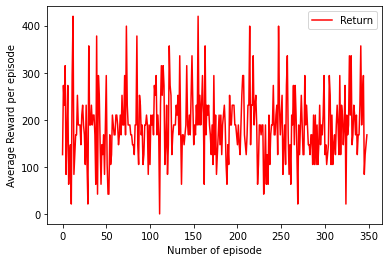

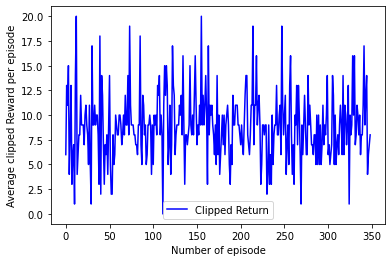

In [10]:
num_epis_count = epis_count-0
bandwidth = 1 # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count)-bandwidth)
total_rew = np.zeros(int(num_epis_count)-bandwidth)
for i in range(int(num_epis_count)-bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i+bandwidth])/bandwidth
    total_rew[i] = np.sum(tot_reward[i:i+bandwidth])/bandwidth
t = np.arange(int(num_epis_count)-bandwidth)
fig = plt.figure()
belplt = plt.plot(t,total_rew[0:int(num_epis_count)-bandwidth],"r", label = "Return")
plt.legend()#handles[likplt,belplt])
print('Running after %d number of episodes' %epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t,total_clipped[0:opt.num_episode-bandwidth],"b", label = "Clipped Return")
plt.legend()#handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN_Clipped.png')


### Accumulated average reward after 8000 episodes of game Assault
|![](./Assualt_DDQN.png)|![](./Assualt_DDQN_Clipped.png)|
|:---------------:|:---------------:|
|Average reward|Average clipped reward|